In [1]:
import torch
import zipfile
import os
import decimal as d
import numpy as np
import json
import unet
import image_processor
import torchvision
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
import pickle
import fnmatch

In [6]:
def modelLoader(model, path: str):
    return model.load_state_dict(torch.load(path))

#thanks, Chat GPT
def unzip_file(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

#thanks, Chat GPT
def sortFirstNFiles(directoryPath: str, n: int = 10):
    allFiles = [os.path.join(directoryPath, file) for file in os.listdir(directoryPath) if file.endswith(('pt', '.pt'))]
    #sorts filenames based on third segment (validationloss in name)
    sortedFiles = sorted(allFiles, key = lambda fileName: int(fileName.split(os.sep)[-1].split('_')[2]))

    firstFiles = sortedFiles[:n]

    return firstFiles

def mapImageTensor(tensor: torch.Tensor, center = 0, scale = 1):
    return 1/ (1 + torch.exp(-(tensor - center)/scale))

def highPrecisionArray(numOfSamples, beg=0, last=1, precision = 4):
    d.getcontext().prec = precision
    start = d.Decimal(beg)
    end = d.Decimal(last)
    step = (end - start) / d.Decimal(numOfSamples - 1)
    numArray = [start + i * step for i in range(numOfSamples)]
    numArray = [float(x) for x in numArray]
    return numArray

def metrics(pred, label):
    if torch.is_tensor(pred) or torch.is_tensor(label):
        pred = pred.detach().cpu().numpy()
        label = label.detach().cpu().numpy()
    
    TP = ((label == 255) & (pred == 255)).sum()
    FP = ((label == 0) & (pred == 255)).sum()
    TN = ((label == 0) & (pred == 0)).sum()
    FN = ((label == 255) & (pred == 0)).sum()

    return int(TP), int(FP), int(TN), int(FN)

def dice(TP, FP, FN):
    if (2*TP + FP + FN) == 0:
        return 0
    return round(2*TP / ( 2*TP + FP + FN), 3)

#thanks, Chat GPT
def rectTriArea(x_values, y_values):
    n = len(x_values)
    area = 0.0
    for i in range(1, n):
        width = x_values[i] - x_values[i - 1]
        height = min(y_values[i - 1], y_values[i])
        rectArea = width*height

        deltaHeight = max(y_values[i], y_values[i-1]) - height

        triArea = .5 * deltaHeight*width
        area += rectArea + triArea
    return area

def framePlotter(pred , label, frameNum: int, caseNum: int, modelName: str, saveDir: str):
    if torch.is_tensor(pred) or torch.is_tensor(label):
        pred = pred.detach().cpu().numpy()
        label = label.detach().cpu().numpy()
    plt.subplot(2,1,1)
    plt.imshow(pred.transpose(1,2,0))
    #parts = modelName.split("\\")
    #modelName = parts[3]
    plt.title(f'Pred- {modelName} | C: {caseNum} F: {frameNum}')

    plt.subplot(2,1,2)
    plt.imshow(label.transpose(1,2,0))
    plt.title(f'Label- {modelName} | C: {caseNum} F: {frameNum}')
    savePath = os.path.join(saveDir, modelName + '_C_' + str(caseNum) + '_F_' + str(frameNum) + '.png')
    plt.savefig(savePath)
    plt.show()

def findLogModels(logModelDir, modelName):
    matches = []
    for root, dirnames, filenames in os.walk(logModelDir):
        for filename in filenames:
            if fnmatch.fnmatch(filename, f'*{modelName}*'):
                matches.append(os.path.join(root, filename))
    return matches

def sigmoidalCurve(x, a, s, c):
    return a / (1 + np.exp(-s * (x - c)))

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:

"""
sigmoid val tensors
flatten val tensors
add flattened val tensors to array
flatten and add to list labels
polytransform array to Z dimension
logistic regresson on Z, list labels
apply model to predict result of sig-flat test images
construct prediction label from output list
compare pred label to label
"""

"""
size of Z dim = (n+(d-1))Cd 
(n+(d-1)) Choose d degrees
"""

"""
Take val data
Fit curve to val data
find threshold through search
take fit curve and threshold and apply to test set
compare
"""

degree = 2
downscale = 16
testCases = 4
imagesPerTestCase = 100
numOfModelsToTest = 1
height = int(256/downscale)
width = int(1024/downscale)
shape = (height, width)

logModelDir = r"C:\Users\myfir\My Drive\Segmentation_Files\Performance_Results\5-9\LogModelAndGraphs"
modelDirectory = r"C:\Users\myfir\My Drive\Segmentation_Files\Models\Test\unet"

thresholds = highPrecisionArray(31, 0, 1, 5)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((height, width))])


logModelImagePath = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\train_val\Rename_TrainVal_Image"
logModelLabelPath = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\train_val\Rename_TrainVal_Label"
segmentationPath = f"{logModelDir}\Segmentations"

if not os.path.exists(segmentationPath):
    os.makedirs(segmentationPath)

testImagePath = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\test\Rename_Test_Image"
testLabelPath = r"C:\Users\myfir\My Drive\Segmentation_Files\Datasets\Rename_Data\test\Rename_Test_Label"

topModelPaths = sortFirstNFiles(modelDirectory, numOfModelsToTest)

logModelFitLoader= image_processor.imageDirsToTestLoader(imageDir=logModelImagePath, labelDir= logModelLabelPath, transform=transform)
testLoader = image_processor.imageDirsToTestLoader(imageDir=testImagePath, labelDir=testLabelPath, transform=transform)

for modelPath in topModelPaths:
    currentTime = datetime.now()
    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    print(f'START: {modelPath} | {formatTime}')
    print(f'Starting Log Model Loader')
    model = unet.unet()
    model.loadAttributes(modelPath)
    model.to(device)
    model.eval()

    listOfFlattenedOutputs = []
    listOfLabels = []

    for i, (image, label) in enumerate(logModelFitLoader):
        #with batch size of 1, i ranges from 0-399 in test set of 400 images
        #0-879 for training set
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        #output = mapImageTensor(output)
        outputArray = output.detach().cpu().numpy().reshape(-1)
        labelArray = label.detach().cpu().numpy().reshape(-1)

        listOfFlattenedOutputs.append(outputArray)
        listOfLabels.append(labelArray)
    
    arrayOfFlattenedOutputs = np.array(listOfFlattenedOutputs).reshape(-1,1)
    poly = PolynomialFeatures(degree = degree)
    #each column in input is a 
    #880, 525825
    #transformedArrayOfFlattenedOutputs = poly.fit_transform(arrayOfFlattenedOutputs)
    #880, 1024
    arrayOfLabels = np.array(listOfLabels).reshape(-1)

    logModel = LogisticRegression().fit(arrayOfFlattenedOutputs, arrayOfLabels)

    probabilities = logModel.predict_proba(arrayOfFlattenedOutputs)

    bestScore = 0
    bestThreshold = 0

    currentTime = datetime.now()
    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    print(f'START: Threshold Search | {formatTime}')

    for i, t in enumerate(thresholds):
        currentTime = datetime.now()
        formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
        print(f'START: Threshold: {t} | {formatTime}')
        yPred = (probabilities[:, 1] > t).astype(int)
        yPredArray = np.array(yPred)
        yPredArray[yPredArray > .9] = 255
        TP, FP, TN, FN = metrics(yPredArray, arrayOfLabels)
        score = dice(TP, FP, FN)
        if score > bestScore:
            bestScore = score
            bestThreshold = t
    
    logModelName = f'logModel_{model.name}_degree_{degree}_dice_{bestScore}_t_{bestThreshold}'
    logModelPath = os.path.join(logModelDir, f'{logModelName}.pkl')

    with open(logModelPath, 'wb') as file:
        pickle.dump(logModel, file)



START: C:\Users\myfir\My Drive\Segmentation_Files\Models\Test\unet\unet16x_VL_98_CE_144_TE_400_LR_0.001_BS_16_TS_2024-04-12_22-46-01.pt | 2024-05-09 21:04:44
Starting Log Model Loader
START: Threshold Search | 2024-05-09 21:05:43
START: Threshold: 0.0 | 2024-05-09 21:05:43
START: Threshold: 0.033333 | 2024-05-09 21:05:43
START: Threshold: 0.066666 | 2024-05-09 21:05:43
START: Threshold: 0.099999 | 2024-05-09 21:05:43
START: Threshold: 0.13333 | 2024-05-09 21:05:43
START: Threshold: 0.16666 | 2024-05-09 21:05:43
START: Threshold: 0.2 | 2024-05-09 21:05:43
START: Threshold: 0.23333 | 2024-05-09 21:05:43
START: Threshold: 0.26666 | 2024-05-09 21:05:43
START: Threshold: 0.3 | 2024-05-09 21:05:43
START: Threshold: 0.33333 | 2024-05-09 21:05:43
START: Threshold: 0.36666 | 2024-05-09 21:05:43
START: Threshold: 0.4 | 2024-05-09 21:05:43
START: Threshold: 0.43333 | 2024-05-09 21:05:43
START: Threshold: 0.46666 | 2024-05-09 21:05:43
START: Threshold: 0.5 | 2024-05-09 21:05:43
START: Threshold: 0

START: C:\Users\myfir\My Drive\Segmentation_Files\Models\Test\unet\unet16x_VL_98_CE_144_TE_400_LR_0.001_BS_16_TS_2024-04-12_22-46-01.pt | 2024-05-09 21:21:39
Starting Log Model Loader
Analyzing unet16x_VL_98_CE_144_TE_400_LR_0.001_BS_16_TS_2024-04-12_22-46-01 on Log Model C:\Users\myfir\My Drive\Segmentation_Files\Performance_Results\5-9\LogModelAndGraphs\logModel_unet16x_VL_98_CE_144_TE_400_LR_0.001_BS_16_TS_2024-04-12_22-46-01_degree_2_dice_0.976_t_0.066666.pkl


ValueError: axes don't match array

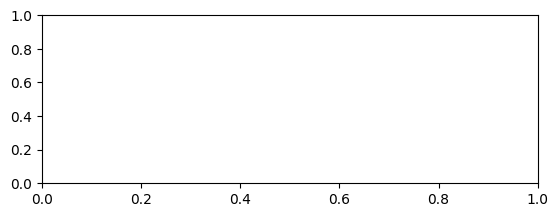

In [11]:


for modelPath in topModelPaths:
    currentTime = datetime.now()
    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    print(f'START: {modelPath} | {formatTime}')
    print(f'Starting Log Model Loader')
    model = unet.unet()
    model.loadAttributes(modelPath)
    model.to(device)
    model.eval()
    
    poly = PolynomialFeatures(degree = degree)
    matches = findLogModels(logModelDir, model.name)

    for match in matches:
        print(f'Analyzing {model.name} on Log Model {match}')
        with open(match, 'rb') as file:
            logModel = pickle.load(file)
        parts = match.split('_')
        parts = parts[-1].split('.pkl')
        t = float(parts[0])
        diceByFrame = [0]*100
        caseNum = 0
        
        #done with a batch size of one to not stress equipment
        for i, (image, label) in enumerate(testLoader):
            #with batch size of 1, i ranges from 0-399 in test set of 400 images
            #0-779 for training set
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            #output = mapImageTensor(output)
            #(1024,)
            outputArray = output.detach().cpu().numpy().reshape(-1,1)
            #(256/downscale, 1024/downscale)
            labelArray = label.detach().cpu().numpy().reshape(shape)

            #arrayOfFlattenedOutputs = np.array(listOfFlattenedOutputs).reshape(-1,1)
            #arrayOfLabels = np.array(listOfLabels).reshape(-1)
            #transformedArrayOfFlattenedOutputs = poly.fit_transform(outputArray)
            probabilities = logModel.predict_proba(outputArray)
            yPred = (probabilities[:, 1] > t).astype(int)
            yPredArray = np.array(yPred).reshape(shape)


            TP, FP, TN, FN = metrics(yPredArray, labelArray)
            score = dice(TP, FP, FN)

            #reshaping flattened array to graph predictions
            yPredArray.reshape(shape)
            labelArray.reshape(shape)

            frameNum = i%100
            if frameNum == 0:
                caseNum += 1

            diceByFrame[frameNum] += score
            framePlotter(pred=yPredArray, label=labelArray, frameNum=frameNum, caseNum=caseNum, modelName= match, saveDir=segmentationPath)

            

        diceByFrame = list(map(lambda x: x * .25, diceByFrame))

        plt.plot(diceByFrame)
        plt.title(f"Avg. Dice by Frame for {match}")
        plt.show()






In [5]:
modelDirectory = r""
thresholds = highPrecisionArray(20, 0, 1, 5)
scales = highPrecisionArray(20, 1 , 500)
centers = highPrecisionArray(25, 0, 255)
scaleCentersProduct = list(itertools.product(scales, centers))

#downscale = torchvision.transforms.Compose([
#    torchvision.transforms.Resize((16, 64))])

testImagePath = r""
testLabelPath = r""

topModelPaths = sortFirstNFiles(modelDirectory, 1)
logModelFitLoader= image_processor.imageDirsToTestLoader(imageDir=testImagePath, labelDir= testLabelPath)

allDiceResults = {path : {} for path in topModelPaths}
allMetricResults = {path : {} for path in topModelPaths}
#allFrameResults = {path : {} for path in topModelPaths}

for modelPath in topModelPaths:
    currentTime = datetime.now()
    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    print(f'START: {modelPath} | {formatTime}')
    model = unet.unet()
    model.load_state_dict(torch.load(modelPath))
    #model.to(device)
    model.eval()
    

    diceResultsByScaleCenter = {f'{s}, {c}': {} for s, c in scaleCentersProduct}
    metricResultsByScaleCenter = {f'{s}, {c}': {} for s, c in scaleCentersProduct}
    #predLabelResultsByScaleCenter = {f'{s}, {c}': {} for s, c in scaleCentersProduct}

    for s, c in scaleCentersProduct:
        currentTime = datetime.now()
        formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
        print(f'SCALE: {s} - CENTER: {c} | {formatTime}')

        diceByThreshold = {str(t): [0]*100 for t in thresholds}
        metricsByThreshold = {str(t): [[0, 0, 0, 0]]*100 for t in thresholds}
        #caseByThreshold = {str(t): {str(i+1): [] for i in range(len(testLoader))} for t in thresholds}

        for i, (image, label) in enumerate(logModelFitLoader): #batch of 100
            #image = image.to(device)
            #label = label.to(device)
            pred = model(image)

            predSig = mapImageTensor(pred, center= c, scale= s)

            for j in range(predSig.size(0)): #split each batch to single frames
                frameImage = predSig[j, :, :, :]
                frameLabel = label[j, :, :, :]

                for t in thresholds:
                        predThresh = torch.where(frameImage <= t, 0, 255)
                        
                        
                        TP, FP, TN, FN = metrics(predThresh, frameLabel)

                        diceCoeffPerFrame = dice(TP, FP, FN)

                        diceByThreshold[str(t)][j] += diceCoeffPerFrame

                        for k, metric in enumerate([TP, FP, TN, FN]):
                             metricsByThreshold[str(t)][j][k] += metric


                        #caseByThreshold[str(t)][str(i+1)].append([predThresh.cpu().detach(), frameLabel.cpu().detach()])

                        #oldTP, oldFP, oldTN, oldFN = metricsByThreshold[str(t)][j]
                        #newTP = oldTP + TP
                        #newFP = oldFP + FP
                        #newTN = oldTN + TN
                        #newFN = oldFN + FN
                        #metricsByThreshold[str(t)][j] = (newTP, newFP, newTN, newFN)

                            

        for t in thresholds:
            diceByThreshold[str(t)] = [val * .25 for val in diceByThreshold[str(t)]]
            #metricsByThreshold[str(t)] = [[val * .25 for val in metricByFrame] for metricByFrame in metricsByThreshold[str(t)]]

                      
        metricResultsByScaleCenter[f'{s}, {c}'] = metricsByThreshold
        diceResultsByScaleCenter[f'{s}, {c}'] = diceByThreshold
        #predLabelResultsByScaleCenter[f'{s}, {c}'] = caseByThreshold

    allDiceResults[modelPath] = diceResultsByScaleCenter
    allMetricResults[modelPath] = metricResultsByScaleCenter
    #allFrameResults[modelPath] = predLabelResultsByScaleCenter



FileNotFoundError: [WinError 3] The system cannot find the path specified: ''

In [ ]:
currentTime = datetime.now()
formatTime = currentTime.strftime("%Y-%m-%d_%H-%M-%S")
parentResultsPath = r""
diceSavePath = f'{parentResultsPath}\\allDiceResults_{formatTime}.txt'
metricSavePath = f'{parentResultsPath}\\allMetricResults_{formatTime}.txt'
#frameSavePath = f'{parentResultsPath}\\allFrameResults_{formatTime}.txt'

with open(diceSavePath, 'w') as saveFile:
    saveFile.write(json.dumps(allDiceResults))

"""
edit = {path : {} for path in topModelPaths}

for modelPath in topModelPaths:
    edit1 = {f'{s}, {c}': {} for s, c in scaleCentersProduct}
    for s,c in scaleCentersProduct:
        edit2 = {str(t): []*100 for t in thresholds}
        for t in thresholds:
            listOfLists = allMetricResults[modelPath][f'{s}, {c}'][f'{t}']
            for l in listOfLists:
                change = list(map(int, l))
                edit2[f'{t}'].append(change)
        edit1[f'{s}, {c}'] = edit2
    edit[modelPath] = edit1
"""

    
with open(metricSavePath, 'w') as saveFile:
    saveFile.write(json.dumps(allMetricResults))

#torch.save(allFrameResults, frameSavePath)


#topAreas = [(0,0,0,0)]* len(scales) * len(thresholds)
topAreas = []
frameData = [n for n in range(1, 101)]

for modelPath in topModelPaths:
    for s, c in scaleCentersProduct:
        for t in thresholds:
            diceList = allDiceResults[modelPath][f'{s}, {c}'][str(t)]
            area = rectTriArea(frameData, diceList)
            
            topAreas.append((modelPath, s, c, t, area))

topAreas = sorted(topAreas, key= lambda x : x[4], reverse= True)

allModelNames = ""
for modelName in topModelPaths:
    allModelNames = allModelNames + modelName +'\n'

areasResult = {str(i): [] for i in range(len(topAreas)+1)}
areasResult['0'].append(f'''Search results for: \n 
                    {allModelNames} 
                    {len(scales)} Scales from [{scales[0]} {scales[-1]}\n 
                    {len(centers)} Centers from [{centers[0]} {centers[-1]}\n 
                    {len(thresholds)} Thresholds from [{thresholds[0]} {thresholds[-1]}\n 
                    ''')

for i in range(len(topAreas)):
    areasResult[f'{i+1}'] = topAreas[i]

currentTime = datetime.now()
formatTime = currentTime.strftime("%Y-%m-%d_%H-%M-%S")
areaParamPath = f'{parentResultsPath}\Area_and_Params_{formatTime}.txt'

with open(areaParamPath, 'w') as saveFile:
    saveFile.write(json.dumps(areasResult))
    
#with open(areaParamPath, 'w') as saveFile:
#    allModelNames = ""
#    for modelName in topModelPaths:
#        allModelNames = allModelNames + modelName +'\n'
#    infoString = f'''Search results for: \n 
#                    {allModelNames} 
#                    {len(scales)} Scales from [{scales[0]} {scales[-1]}\n 
#                    {len(centers)} Centers from [{centers[0]} {centers[-1]}\n 
#                    {len(thresholds)} Thresholds from [{thresholds[0]} {thresholds[-1]}\n 
#                    '''
#    saveFile.write(infoString)
#    for tup in topAreas:
#        saveFile.write(str(tup) + '\n')

In [ ]:
try:
    topAreas = globals()[topAreas]
    topAreas = topAreas[10:]
    print('Loading Top Areas from local variable...')
except:
    areasResultFilePath = r'' #your path here
    print('Loading Top Areas from file path...')
    with open(areasResultFilePath, 'r') as file:
        areasResult = json.load(file)
    topAreas = []
    for i in range(1,len(areasResult)):
        topAreas.append(areasResult[str(i)])

try:
    allDiceResults = globals()[allDiceResults]
    print('Loading All Dice Results from local variable...')
except:
    allDiceFilePath = r'' #your path here
    print('Loading All Dice Results from file path...')
    with open(allDiceFilePath, 'r') as file:
        allDiceResults = json.load(file)  

try:
    allMetricResults = globals()[allMetricResults]
    print('Loading All Metrics Results from local variable...')
except:
    allMetricsFilePath = r'' #your path here
    print('Loading All Metrics Results from file path...')
    with open(allMetricsFilePath, 'r') as file:
        allMetricResults = json.load(file)  

""""
if allFrameResults:
    print('Loading All Frame Results from local variable...')
else:
    allFrameFilePath = '' #your path here
    print('Loading All Frame Results from file path...')
    allFrameResults = torch.load(allFrameFilePath)
"""

In [ ]:
xCoords = [n for n in range(1, 101)]
n = 5
currentTime = datetime.now()
formatTime = currentTime.strftime("%Y-%m-%d_%H-%M-%S")
topNResultPath = f'{parentResultsPath}\\Top_{n}_Dice_Graph{formatTime}.png'
top1ResultPath = f'{parentResultsPath}\\Top_1_Dice_Graph{formatTime}.png'

for i in range(n):
    modelPath = topAreas[i][0]
    modelScale = topAreas[i][1]
    modelCenter = topAreas[i][2]
    modelThresh = topAreas[i][3]
    parts = modelPath.split("\\")
    modelName = parts[3]
    yCoords = allDiceResults[modelPath][f'{modelScale}, {modelCenter}'][str(modelThresh)]
    plt.plot(xCoords, yCoords, label = f'{modelName} | S: {modelScale} | C: {modelCenter} | T: {modelThresh}')

plt.title(f"Top {n} Results by Model Params")
plt.legend(fontsize = 'small', loc = 'upper left', bbox_to_anchor=(1,1))
plt.savefig(topNResultPath)
plt.show()

xCoords = [n for n in range(1, 101)]
n = 1

for i in range(n):
    modelPath = topAreas[i][0]
    modelScale = topAreas[i][1]
    modelCenter = topAreas[i][2]
    modelThresh = topAreas[i][3]
    parts = modelPath.split("\\")
    modelName = parts[3]
    yCoords = allDiceResults[modelPath][f'{modelScale}, {modelCenter}'][str(modelThresh)]
    plt.plot(xCoords, yCoords, label = f'{modelName} | S: {modelScale} | C: {modelCenter} | T: {modelThresh}')

plt.title(f"Top Result by Model Params")
plt.legend(fontsize = 'small', loc = 'upper left', bbox_to_anchor=(1,1))
plt.savefig(top1ResultPath)
plt.show()

In [ ]:
topModelParams = []

topModelNum = 1

#downscale = torchvision.transforms.Compose([
#    torchvision.transforms.Resize((16, 64))])

testImagePath = r""
testLabelPath = r""

logModelFitLoader= image_processor.imageDirsToTestLoader(imageDir=testImagePath, labelDir= testLabelPath)

for i in range(topModelNum):
    topModelParams.append([topAreas[i][0], topAreas[i][1], topAreas[i][2], topAreas[i][3]])

segmentationPath = f"{parentResultsPath}\Segmentations"

if not os.path.exists(segmentationPath):
    os.makedirs(segmentationPath)


for modelName, s, c, t in topModelParams:
    currentTime = datetime.now()
    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    print(f'START: {modelName} | {formatTime}')
    model = unet.unet()
    model.load_state_dict(torch.load(modelName))
    #model.to(device)
    model.eval()

    for case, (image, label) in enumerate(logModelFitLoader):
        #image = image.to(device)
        #label = label.to(device)
        
        pred = model(image)

        predSig = mapImageTensor(pred, center= c, scale= s)
        
        for frame in range(predSig.size(0)): #split each batch to single frames
            frameImage = predSig[frame, :, :, :]
            frameLabel = label[frame, :, :, :]
            predThresh = torch.where(frameImage <= t, 0, 255)

            framePlotter(predThresh, frameLabel, frame+1, case+1, modelName, segmentationPath)
    

    #for s, c in scaleCentersProduct:
    #    currentTime = datetime.now()
    #    formatTime = currentTime.strftime("%Y-%m-%d %H:%M:%S")
    #    print(f'SCALE: {s} - CENTER: {c} | {formatTime}')
        

        #for case in range(len(allFrameResults[modelPath][f'{s}, {c}'][f'{t}'])): #for every case
        #    for frame, (predMask, label) in enumerate(allFrameResults[modelPath][f'{s}, {c}'][f'{t}'][f'{case+1}']): #for every frame
        #        framePlotter(predMask, label, frame+1, case+1, modelPath, segmentationPath)

